Created by Alberto Ueda at 2017-01-09. Based on experiments of Sabir thesis.

# JCDL 2017

In [1]:
N_AUTHORS = None

%pylab inline

import sys
sys.path.append('../../../../../ufmg-latin/pscore/rfs/')

import rfslib.rankmodels
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import rfslib.datasets
dataset = rfslib.datasets.DBLPDataset('../../../../../pscore/datasets/',nauthors=N_AUTHORS)
dataset.prepare()
venuerank  = dataset.dfvenues.copy()
authorrank = dataset.dfauthors.copy()
grouprank  = dataset.dfgroups.copy()

Populating the interactive namespace from numpy and matplotlib
(1595771, 1) authors
(1595771, 1) authors loaded


../../../../../ufmg-latin/pscore/rfs/rfslib/datasets.py:72: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df = df.sort(['AID','VID','PID']).set_index(authorpaper.AID)


In [30]:
import rfslib.pscorefactory
pscore = rfslib.pscorefactory.PScoreRankFactory(dataset,cpp=True,ranksize=1000,fullrank=True)

In [2]:
# Returns 3 rankings: venues, authors and groups
# Calculate the rankings based on previous rankings, 
def run_pscore(params,venuerank,authorrank,grouprank,field):
    
    dranks = pscore.rank(params)
    vrank,arank,grank = dranks['venues'],dranks['authors'],dranks['groups']
    vscore,ascore,gscore = vrank['Score'],arank['Score'],grank['Score']

    # add new score to dfrank with the name 'field' 
    rfslib.rankmodels.addscore(venuerank, vscore,field)
    rfslib.rankmodels.addscore(authorrank,ascore,field)
    rfslib.rankmodels.addscore(grouprank, gscore,field)
    
    return vrank,arank,grank

def head_ranks(n=5): 
    print vrank.sort_values(by='Score',ascending=False).head(n), '\n\n', 
    print arank.sort_values(by='Score',ascending=False).head(n), '\n\n', 
    print grank.sort_values(by='Score',ascending=False).head(n)

In [3]:
import rfslib.ndcg
def plot_ndcg_k(dfrank,features,relfield,namefield,N=25,n=1,filename=None,verbose=True):
    ks = range(1,1+N)
    dfndcg = pd.DataFrame(index=ks)
    xs = range(n,N+1,n)

    for feature in features:
        ranking = dfrank.sort_values(by=feature['name'],ascending=False)
        ranking = ranking.head(N) # uncomment to get only the head
        #ranking = ranking[~pd.isnull(ranking[feature['name']])] # uncomment to filter NAs
        ys = ranking[relfield].tolist()
        names = ranking[namefield].tolist()
        ndcg_at_k = [ rfslib.ndcg.get_ndcg(ys,k) for k in ks[:len(ys)] ]
        
        if not feature.has_key('label'):
            feature['label'] = feature['name']
        
        dfndcg[feature['label']] = pd.Series(ndcg_at_k,index=dfndcg.index[:len(ys)])

        if verbose == True:
            print 'FEATURE:',feature['name']
            print ['%i|%s' % (y,name) for (y,name) in zip(ys,names)],len(ys)
            print

    feature_labels  = [ f['label']  for f in features ]
    feature_styles = [ f['style'] for f in features ]
    ax = dfndcg.loc[xs,feature_labels].plot(lw = 1,grid=5,style=feature_styles)

    ax.minorticks_on()
    ax.set_xlabel("k")
    ax.set_ylabel("nDCG@k")
    ax.set_xlim((0,N+(N*0.03)))
    ax.set_ylim((0,1.05))
    
    if filename != None:
        savefig(filename)   

def get_authors(vkeys=None, vids=None):    
    vauthors = []    

    # TODO Refactoring
    if vids is not None:
        for vid in vids: 
            vkey = dataset.dfvenues.loc[vid].Vkey
            authorrank_ = dataset.dfauthors.copy()
            authorrank_[vkey] = dataset.df[dataset.df.VID==vid].groupby(level=0).PID.count() # TODO local h-index
            df_ = authorrank_[~pd.isnull(authorrank_[vkey])]                                 # TODO aggregate counts
            vauthors += df_.index.map(int).tolist()      
    else:
        for vkey in vkeys: 
            vid  = dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] 
            authorrank_ = dataset.dfauthors.copy()
            authorrank_[vkey] = dataset.df[dataset.df.VID==vid].groupby(level=0).PID.count()
            df_ = authorrank_[~pd.isnull(authorrank_[vkey])]
            vauthors += df_.index.map(int).tolist()  

    return sorted(set(vauthors))

## Ground Truth (CNPq Productivity Levels)

In [33]:
df = dataset.dfcnpqdblp.sort_index().drop_duplicates('Akey').reset_index().set_index('Akey') # drop duplicates
df = df.join(authorrank.reset_index().set_index('Akey'),rsuffix='_')
df = df.reset_index().set_index('CNPq_Id')
df = df.join(dataset.dfcnpq)
df['CNPq_Id'] = df.index
df = df.set_index('index')
df['CNPqLevelRel'] = pd.Series()
df['CNPqLevelRel'] = df['CNPqLevel'].replace({'1A':5,'1B':4,'1C':3,'1D':2,'2':1,np.nan:0})
df['CNPqLevelRel'].unique()

df = df.reset_index().set_index('CNPq_Id').sort_index()

cols_to_sum = df.columns.difference(dataset.dfcnpq.columns).difference([u'CNPqLevelRel', u'index'])
df2 = df.loc[:,cols_to_sum].groupby(level=0).sum()
df2 = df2.join(df.reset_index().drop_duplicates('CNPq_Id').set_index('CNPq_Id'),rsuffix='_')
hide = ['index','Akey','APsize_','GS_Name','Begin','End','GS_Name.1','GS_Link']
df2.loc[:,df2.columns.difference(hide)]
df2.rename(columns={'GS_Cits':'Citations','GS_H5':'H-Index'},inplace=True)

authorrankbr = df2
rankauthors = sorted(authorrankbr['index'].dropna().map(int).values.tolist())

authorrankbr.head()

,APsize,Most Cited Authors,Seeds: SIGIR+TOIS,index,Akey,APsize_,Most Cited Authors_,Seeds: SIGIR+TOIS_,Name,GS_Name,...,Begin,End,University,GS_Name.1,GS_Link,H-Index,Citations,GS_H5_2010,GS_Cits_2010,CNPqLevelRel
CNPq_Id,,,,,,,,,,,,,,,,,,,,,
0,33.0,4433.0,11.0,45098.0,Abilio Lucena,33.0,4433.0,11.0,Abilio Pereira de Lucena Filho,NaN,...,01/03/14,28/02/2018,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,3
1,48.0,3088.0,9.0,29497.0,Adenilso da Silva Simão,44.0,3088.0,9.0,Adenilso da Silva Simão,Adenilso Simao,...,01/03/13,29/02/2016,USP,Adenilso Simao,/citations?user=gdT5wnMAAAAJ&hl=pt-BR,13.0,632.0,12.0,460.0,1
2,72.0,4623.0,33.0,23509.0,Adriana Santarosa Vivacqua,53.0,4623.0,33.0,Adriana Santarosa Vivacqua,NaN,...,01/03/13,29/02/2016,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,1
3,67.0,14661.0,1785.0,17464.0,Adriano Veloso,64.0,14661.0,1785.0,Adriano Alonso Veloso,Adriano Veloso,...,01/03/12,28/02/2015,UFMG,Adriano Veloso,/citations?user=j2BEVSoAAAAJ&hl=pt-BR,17.0,1003.0,16.0,716.0,1
4,78.0,6175.0,24.0,20073.0,Adriano L. I. Oliveira,59.0,6175.0,15.0,Adriano Lorena Inacio de Oliveira,Adriano L I Oliveira,...,01/03/13,29/02/2016,UFPE,Adriano L I Oliveira,/citations?user=paz29H4AAAAJ&hl=pt-BR,14.0,675.0,11.0,443.0,1


In [945]:
for i in range(10):
    print rankauthors[i]

628
650
1154
1317
1583
1767
1771
1902
2171
2189


In [5]:
authorrankbr.head()

,APsize,index,Akey,APsize_,Name,GS_Name,CNPqLevel,Begin,End,University,GS_Name.1,GS_Link,H-Index,Citations,GS_H5_2010,GS_Cits_2010,CNPqLevelRel
CNPq_Id,,,,,,,,,,,,,,,,,
0,33.0,45098.0,Abilio Lucena,33.0,Abilio Pereira de Lucena Filho,NaN,1C,01/03/14,28/02/2018,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,3
1,48.0,29497.0,Adenilso da Silva Simão,44.0,Adenilso da Silva Simão,Adenilso Simao,2,01/03/13,29/02/2016,USP,Adenilso Simao,/citations?user=gdT5wnMAAAAJ&hl=pt-BR,13.0,632.0,12.0,460.0,1
2,72.0,23509.0,Adriana Santarosa Vivacqua,53.0,Adriana Santarosa Vivacqua,NaN,2,01/03/13,29/02/2016,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,1
3,67.0,17464.0,Adriano Veloso,64.0,Adriano Alonso Veloso,Adriano Veloso,2,01/03/12,28/02/2015,UFMG,Adriano Veloso,/citations?user=j2BEVSoAAAAJ&hl=pt-BR,17.0,1003.0,16.0,716.0,1
4,78.0,20073.0,Adriano L. I. Oliveira,59.0,Adriano Lorena Inacio de Oliveira,Adriano L I Oliveira,2,01/03/13,29/02/2016,UFPE,Adriano L I Oliveira,/citations?user=paz29H4AAAAJ&hl=pt-BR,14.0,675.0,11.0,443.0,1


# Computing Rankings

## I - Venues as sources

###   Feature: Test

In [513]:
field = 'Test'

params = dict(area=1,
              model='P-score',  # TODO: Range too large + low RAM memory throws exception: 
              year=(1940,2010), #       json.loads(resultstring) in pscorefactory
              refvenues=[247],  # SIGIR
              fullrank=True,
              rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
print (vrank.sort_values(by='Score',ascending=False).head())
print (arank.sort_values(by='Score',ascending=False).head())
print (grank.sort_values(by='Score',ascending=False).head())

             Vkey  VPsize  VPyear    Score
247    conf/sigir  3545.0  1971.0  40818.0
445     conf/trec  1788.0  1992.0  17480.0
184     conf/cikm  4333.0  1992.0  14879.0
969     conf/clef  2767.0  2000.0   8695.0
629  journals/ipm  2616.0  1963.0   8068.0
                         Akey  APsize  Score
1317   Marcos André Gonçalves     213    9.0
7054            Nivio Ziviani     103    8.0
9897    Edleno Silva de Moura      90    6.0
1154         Wagner Meira Jr.     223    4.0
36536            Marco Cristo      39    4.0
                                           Name  NRC5  NRC95  Score
18          University of Massachusetts Amherst   9.0   36.0  116.0
4    University of Illinois at Urbana-Champaign   3.0   18.0   32.0
90            University of Illinois at Chicago  67.0  104.0   21.0
3                    Carnegie Mellon University   3.0   10.0   21.0
103            Florida International University  84.0  126.0   20.0


### Seed: Top Venue of Sub-areas

In [509]:
field = 'Venues - Top Venue of Sub-areas'

vkeys = ['conf/stoc','conf/icra','conf/bmei','conf/fecs','conf/cvpr',
         'conf/kdd','conf/vldb','conf/icdcs','conf/siggraph','conf/dac',
         'conf/chi','conf/sigir','conf/nips','conf/spieSR','conf/icassp',
         'conf/infocom','conf/usenix','conf/popl','conf/cdc','conf/issac',
         'conf/crypto','conf/wsc','conf/icse','conf/www','journals/cacm']
refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in vkeys ]

params = dict(area=1,model='P-score',year=(1940,2016),refvenues=refvenues,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
head_ranks()

                 Vkey   VPsize  VPyear     Score
10        conf/icassp  28525.0  1976.0  957739.0
510         conf/icra  16038.0  1992.0  660465.0
293         conf/iros  13604.0  1989.0  461900.0
645  conf/interspeech  17729.0  1987.0  426235.0
534          conf/chi  10697.0  1990.0  352850.0 

                         Akey  APsize  Score
13737          Paulo Oliveira      75   21.0
1317   Marcos André Gonçalves     213   14.0
1154         Wagner Meira Jr.     223   13.0
7054            Nivio Ziviani     103   13.0
9897    Edleno Silva de Moura      90   12.0 

                                     Name  NRC5  NRC95   Score
11        Georgia Institute of Technology   6.0   28.0  1208.0
2   Massachusetts Institute of Technology   3.0    5.0  1163.0
0                     Stanford University   1.0    2.0  1037.0
1       University of California-Berkeley   1.0    2.0  1010.0
3              Carnegie Mellon University   3.0   10.0   948.0


### Seed: Top Venues of a single Sub-area

In [952]:
%%time

# TODO: TOP 100 Venues in IR (50 conf + 50 journals, Microsoft):
irvkeys = ['conf/sigir','conf/www','conf/cikm','conf/sigmod','conf/vldb','conf/icde','conf/kdd',
           'conf/mm','conf/acl','conf/iswc','conf/cvpr','conf/wsdm','conf/aaai','conf/chi','conf/coling',
           'conf/jcdl','conf/emnlp','conf/ecir','conf/lrec','conf/naacl','conf/ijcai','conf/mir',
           'conf/clef','conf/icip','conf/civr','conf/iccv','conf/wi','conf/pods','conf/icdm','conf/icdke',
           'conf/icdar','conf/trec',
           'conf/icml','conf/dexa','conf/recsys','conf/nips','conf/smc','conf/icassp','conf/icpr','conf/ismir',
           'conf/webdb','conf/edbt','conf/widm','conf/eacl','conf/hicss','conf/fois',
           'conf/sac','conf/icmcs','conf/ht', 'conf/esws', # The venues at this line were fixed
           'conf/gis','conf/doceng','conf/iui','conf/kcap','conf/icsc','conf/wise','conf/icwsm' # Extra to get 50
          ] # conf/soda conf/icws
            
irvkeys += ['journals/tkde','journals/jasis','journals/ipm','journals/tois','journals/pami',
            'journals/ws','journals/expert','journals/jasis','journals/ir','journals/bmcbi','journals/tmm',
            'journals/cacm','journals/computer','journals/csur','journals/jamia','journals/bioinformatics',
            'journals/sigir','journals/internet','journals/sigmod','journals/lncs','journals/jei',
            'journals/eswa','journals/ftir','journals/pr','journals/pvldb','journals/jis','journals/jbi',
            'journals/ieeemm','journals/tip','journals/isci','journals/oir','journals/scientometrics',
            'journals/tods','journals/jiis','journals/mta','journals/tvcg','journals/tcsv','journals/debu',
            'journals/jacm','journals/jvcir','journals/biodb','journals/dlib','journals/el',
            ] # 'journals/jd','journals/kbs','journals/ijcat','journals/kais','journals/aslib',
              # 'journals/gis','journals/ijswis','journals/tomccap','journals/prl'

# vkeys not found are printed
for vkey in irvkeys:
    if( vkey not in dataset.dfvenues.Vkey.values):
        print vkey      
        
irvids = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in irvkeys ]        
print len(irvids), ' venues found in dataset'

iraids = get_authors(vids=irvids)
print len(iraids), ' authors found in dataset'

100  venues found in dataset
297101  authors found in dataset
CPU times: user 10.8 s, sys: 51 ms, total: 10.9 s
Wall time: 10.9 s


In [854]:
dataset.dfvenues[dataset.dfvenues.Vkey.str.contains('icme')]

,Vkey,VPsize,VPyear
1170,conf/icmens,366.0,2003.0


In [995]:
field = 'Seeds: MS IR Top Confs' 

refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in irvkeys ]
params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues)
vrank,arank,grank = run_pscore(params,venuerank,authorrankbr,grouprank,field) # TODO: remember to world authors too

vrank.sort_values(by='Score', ascending=False).head(20)        

,Vkey,VPsize,VPyear,Score
10,conf/icassp,28525.0,1976.0,1574372.0
66,conf/icip,17283.0,1994.0,1414219.0
194,conf/cvpr,6874.0,1993.0,736273.0
246,conf/icmcs,7286.0,1994.0,716923.0
645,conf/interspeech,17729.0,1987.0,673550.0
316,conf/icpr,8972.0,1996.0,667243.0
501,conf/icde,4327.0,1984.0,516716.0
161,conf/mm,4156.0,1993.0,512772.0
356,journals/tip,5112.0,1992.0,491382.0
184,conf/cikm,4333.0,1992.0,478644.0


In [996]:
arank.sort_values(by='Score', ascending=False).head(20)        

,Akey,APsize,Score
6,Thomas S. Huang,827,540.0
5,Philip S. Yu,860,435.0
16,Jiawei Han,702,402.0
4,Wen Gao,904,383.0
101,Rama Chellappa,498,320.0
64,Anil K. Jain,558,309.0
160,Shuicheng Yan,400,291.0
192,Aggelos K. Katsaggelos,410,272.0
205,Qi Tian,394,271.0
144,Gerhard Weikum,446,268.0


In [28]:
# Information Retrieval
field = 'Seeds: SIGIR+TOIS' # that's it, it could be the same name of venues

vkeys = ['conf/sigir', 'journals/tois']
refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in vkeys ]

params = dict(area=1,model='P-score',year=(1940,2016),refvenues=refvenues,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrankbr,grouprank,field)
result = arank.sort_values(by='Score', ascending=False).head(20)

#result.to_csv('./output/Ranking of BR Authors by P-score ' + field + '.csv')
result.head()

,Akey,APsize,Score
1317,Marcos André Gonçalves,213,8639.0
9897,Edleno Silva de Moura,90,5435.0
7054,Nivio Ziviani,103,5409.0
6279,Altigran Soares da Silva,113,3954.0
1154,Wagner Meira Jr.,223,3684.0


In [529]:
# 10899 1317 7054
arank[arank['Akey'].str.contains('Berthier A.')]
print (1317 in rankauthors)

True


In [32]:
field = 'Seeds: SIGIR+TOIS'

vkeys = ['conf/sigir', 'journals/tois']
refvenues = [ dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0] for vkey in vkeys ]

params = dict(area=1,model='P-score',year=(1940,2015),refvenues=refvenues)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
result = arank.sort_values(by='Score', ascending=False).head(200)

result.head()
#result.to_csv('./output/Ranking of WR Authors by P-score ' + field + '.csv')

,Akey,APsize,Score
629,W. Bruce Croft,283,48145.0
227,Maarten de Rijke,383,38888.0
1283,ChengXiang Zhai,216,29262.0
3082,James Allan,155,28133.0
1422,Iadh Ounis,211,27955.0


In [24]:
# By previous seeds
result = vrank.sort_values(by='Score', ascending=False).head(50)
#result.to_csv('output/Ranking of Venues by P-score Seeds: SIGIR+TOIS.csv')
result.head(10)

,Vkey,VPsize,VPyear,Score
247,conf/sigir,3545.0,1971.0,397.0
184,conf/cikm,4333.0,1992.0,192.0
1199,conf/ecir,1139.0,1997.0,137.0
445,conf/trec,1788.0,1992.0,131.0
969,conf/clef,2767.0,2000.0,111.0
624,journals/sigir,721.0,1971.0,64.0
629,journals/ipm,2616.0,1963.0,55.0
323,conf/www,4501.0,2001.0,40.0
1004,journals/tois,610.0,1983.0,39.0
576,journals/jasis,5376.0,1973.0,39.0


In [677]:
# By H-index: only venues ranked by P-score
# TODO Currently it needs the venuerank of Visualization section
samevenues = result.index.map(int).tolist()
vhindex = venuerank[venuerank.index.isin(samevenues)][[
        'Vkey', 'Qualis', 'VPsize', 'Citations', 'H-Index']].sort_values(by='H-Index', ascending=False)

# vhindex.to_csv('output/Ranking of Venues by H-Index (SIGIR+TOIS related).csv')
vhindex.head()

,Vkey,Qualis,VPsize,Citations,H-Index
index,,,,,
194,conf/cvpr,A1,6874.0,379400.0,118.0
323,conf/www,A1,4501.0,120253.0,83.0
760,conf/icml,A1,3294.0,290468.0,69.0
758,conf/nips,A1,5684.0,404822.0,66.0
129,conf/sigmod,A1,3706.0,337960.0,61.0


In [678]:
venuerank.head()

,Vkey,VPsize,VPyear,Venues - Top Venue of 1 Sub-area,Venues - Top Venue of Sub-areas,Test,Seeds: SIGIR+TOIS BR,Seeds: SIGIR+TOIS WR,Qualis,QualisRel,H-Index,Citations,Most Cited Authors
index,,,,,,,,,,,,,
0,journals/corr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0,NaN,485635.0,NaN
1,conf/ssp,361.0,2012.0,29.0,7818.0,NaN,29.0,29.0,None,0,NaN,94.0,23.0
2,conf/isit,4224.0,2008.0,192.0,45053.0,41.0,192.0,192.0,B1,5,49.0,15815.0,430.0
3,journals/tcom,7959.0,1989.0,575.0,79853.0,241.0,575.0,575.0,A1,7,NaN,236070.0,670.0
4,journals/twc,5728.0,2002.0,677.0,85526.0,170.0,677.0,677.0,A1,7,NaN,84604.0,639.0


### H-index of Venues' Authors

In [947]:
vkeys = ['conf/sigir', 'journals/tois']
vauthors = get_authors(vkeys)

print len(vauthors), 'authors found in the world'

brauthors = authorrankbr[authorrankbr['index'].isin(vauthors)].sort_values(
    by='H-Index', ascending=False)[['Akey', 'CNPqLevelRel', 'index', 'APsize', 'H-Index']]

print len(brauthors), 'authors found in BR'

#brauthors.to_csv('output/Ranking of BR Authors by H-index (SIGIR, TOIS).csv')
brauthors

5538 authors found in the world
16 authors found in BR


,Akey,CNPqLevelRel,index,APsize,H-Index
CNPq_Id,,,,,
93,Daniel Schwabe,3,5416.0,119.0,36.0
201,Jussara M. Almeida,2,3782.0,143.0,34.0
258,Marcos André Gonçalves,2,1317.0,213.0,34.0
379,Wagner Meira Jr.,3,1154.0,223.0,33.0
290,Nivio Ziviani,5,7054.0,103.0,32.0
8,Alberto H. F. Laender,5,2171.0,180.0,29.0
18,Altigran Soares da Silva,2,6279.0,113.0,26.0
101,Edleno Silva de Moura,2,9897.0,90.0,25.0
330,Ricardo da Silva Torres,2,3694.0,142.0,23.0


In [641]:
#brauthors.to_csv('output/All Rankings of BR Authors.csv')
authorrankbr.head()

,APsize,Seeds: SIGIR+TOIS BR,Seeds: SIGIR+TOIS WR,Test,Venues - Top Venue of 1 Sub-area,Venues - Top Venue of Sub-areas,index,Akey,APsize_,Venues - Top Venue of 1 Sub-area_,...,Begin,End,University,GS_Name.1,GS_Link,H-Index,Citations,GS_H5_2010,GS_Cits_2010,CNPqLevelRel
CNPq_Id,,,,,,,,,,,,,,,,,,,,,
0,33.0,NaN,NaN,NaN,NaN,NaN,45098.0,Abilio Lucena,33.0,NaN,...,01/03/14,28/02/2018,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,3
1,48.0,NaN,NaN,NaN,NaN,NaN,29497.0,Adenilso da Silva Simão,44.0,NaN,...,01/03/13,29/02/2016,USP,Adenilso Simao,/citations?user=gdT5wnMAAAAJ&hl=pt-BR,13.0,632.0,12.0,460.0,1
2,72.0,NaN,NaN,NaN,NaN,1.0,23509.0,Adriana Santarosa Vivacqua,53.0,NaN,...,01/03/13,29/02/2016,UFRJ,NaN,NaN,NaN,NaN,NaN,NaN,1
3,67.0,3.0,3.0,1.0,3.0,7.0,17464.0,Adriano Veloso,64.0,3.0,...,01/03/12,28/02/2015,UFMG,Adriano Veloso,/citations?user=j2BEVSoAAAAJ&hl=pt-BR,17.0,1003.0,16.0,716.0,1
4,78.0,NaN,NaN,NaN,NaN,NaN,20073.0,Adriano L. I. Oliveira,59.0,NaN,...,01/03/13,29/02/2016,UFPE,Adriano L I Oliveira,/citations?user=paz29H4AAAAJ&hl=pt-BR,14.0,675.0,11.0,443.0,1


### Feature: Top Authors in Top Venues of Sub-areas

In [740]:
#field = 'Authors - in Top Venues of Sub-areas'
field = 'Top Venues of Sub-areas'

REFCOUNT  = 5

# Top 1 (50 venues)
#vkeys = ['conf/infocom', 'conf/icra', 'conf/icassp', 'conf/cvpr', 'conf/dac', 'conf/stoc', 'conf/vldb', 'conf/chi', 'conf/nips', 'conf/cdc', 'conf/siggraph', 'conf/spieSR', 'conf/icse', 'conf/sigir', 'conf/popl', 'conf/ismb', 'conf/kdd', 'conf/crypto', 'conf/www', 'conf/icdcs', 'conf/usenix', 'conf/wsc', 'conf/isit', 'conf/fecs', 'conf/issac']
#vkeys+= ['journals/tit', 'journals/pami', 'journals/cacm', 'journals/tsp', 'journals/tcom', 'journals/bioinformatics', 'journals/corr', 'journals/joc', 'journals/tsmc', 'journals/ai', 'journals/tse', 'journals/sigplan', 'journals/tcsv', 'journals/tog', 'journals/ijcv', 'journals/tkde', 'journals/ipl', 'journals/ipl', 'journals/dm', 'journals/sigops', 'journals/tpds', 'journals/internet', 'journals/jcal', 'journals/presence', 'journals/rts']

# Top 2 (100 venues)
#vkeys = ['conf/infocom', 'conf/mobicom', 'conf/icra', 'conf/ijcai', 'conf/icassp', 'conf/nips', 'conf/cvpr', 'conf/iccv', 'conf/dac', 'conf/iscas', 'conf/stoc', 'conf/focs', 'conf/vldb', 'conf/sigmod', 'conf/chi', 'conf/cscw', 'conf/nips', 'conf/icml', 'conf/cdc', 'conf/rtss', 'conf/siggraph', 'conf/visualization', 'conf/spieSR', 'conf/icip', 'conf/icse', 'conf/itc', 'conf/sigir', 'conf/cikm', 'conf/popl', 'conf/ecoop', 'conf/ismb', 'conf/recomb', 'conf/kdd', 'conf/icde', 'conf/crypto', 'conf/eurocrypt', 'conf/www', 'conf/iswc', 'conf/icdcs', 'conf/sc', 'conf/usenix', 'conf/sosp', 'conf/wsc', 'conf/mswim', 'conf/isit', 'conf/icip', 'conf/fecs', 'conf/aied', 'conf/issac', 'conf/iccs']
#vkeys+= ['journals/tit', 'journals/tcs', 'journals/pami', 'journals/pr', 'journals/cacm', 'journals/pieee', 'journals/tsp', 'journals/isci', 'journals/tcom', 'journals/jsac', 'journals/bioinformatics', 'journals/jcb', 'journals/corr', 'journals/siamcomp', 'journals/joc', 'journals/tissec', 'journals/tsmc', 'journals/cad', 'journals/ai', 'journals/fss', 'journals/tse', 'journals/dm', 'journals/sigplan', 'journals/toplas', 'journals/tcsv', 'journals/tmm', 'journals/tog', 'journals/cga', 'journals/ijcv', 'journals/cvgip', 'journals/tkde', 'journals/tods', 'journals/ipl', 'journals/tkde', 'journals/ipl', 'journals/isci', 'journals/dm', 'journals/ijmms', 'journals/sigops', 'journals/tpds', 'journals/tpds', 'journals/tocs', 'journals/internet', 'journals/firstmonday', 'journals/jcal', 'journals/ets', 'journals/presence', 'journals/simulation', 'journals/rts', 'journals/tecs']

# Top 4 (4*25=200 venues)
vkeys = ['conf/infocom', 'conf/mobicom', 'conf/icc', 'conf/vtc', 'conf/icra', 'conf/ijcai', 'conf/aaai', 
         'conf/icml', 'conf/icassp', 'conf/nips', 'conf/acl', 'conf/coling', 'conf/cvpr', 'conf/iccv', 'conf/eccv', 
         'conf/fgr', 'conf/dac', 'conf/iscas', 'conf/iccad', 'conf/ispd', 'conf/stoc', 'conf/focs', 'conf/soda',
         'conf/icalp', 'conf/vldb', 'conf/sigmod', 'conf/icde', 'conf/hicss', 'conf/chi', 'conf/cscw', 'conf/uist', 
         'conf/iui', 'conf/nips', 'conf/icml', 'conf/iros', 'conf/isnn', 'conf/cdc', 'conf/rtss', 'conf/sensys', 
         'conf/ches', 'conf/siggraph', 'conf/visualization', 'conf/gi', 'conf/iv', 'conf/spieSR', 'conf/icip', 
         'conf/mm', 'conf/dcc', 'conf/icse', 'conf/itc', 'conf/cav', 'conf/sac', 'conf/sigir', 'conf/cikm', 
         'conf/trec', 'conf/jcdl', 'conf/popl', 'conf/ecoop', 'conf/pldi', 'conf/oopsla', 'conf/ismb', 'conf/recomb', 
         'conf/cbms', 'conf/eccb', 'conf/kdd', 'conf/icde', 'conf/cikm', 'conf/icdm', 'conf/crypto', 'conf/eurocrypt', 
         'conf/ccs', 'conf/asiacrypt', 'conf/www', 'conf/iswc', 'conf/icws', 'conf/usits', 'conf/icdcs', 'conf/sc', 
         'conf/podc', 'conf/icpp', 'conf/usenix', 'conf/sosp', 'conf/osdi', 'conf/nossdav', 'conf/wsc', 'conf/mswim', 
         'conf/pads', 'conf/anss', 'conf/isit', 'conf/icip', 'conf/wcnc', 'conf/or', 'conf/fecs', 'conf/aied', 
         'conf/sigcse', 'conf/its', 'conf/issac', 'conf/iccs', 'conf/ppsc', 'conf/aisc']
vkeys+= ['journals/tit', 'journals/tcs', 'journals/siamcomp', 'journals/iandc', 'journals/pami', 'journals/pr', 
         'journals/neco', 'journals/ml', 'journals/cacm', 'journals/pieee', 'journals/tc', 'journals/jacm', 
         'journals/tsp', 'journals/isci', 'journals/taslp', 'journals/bsl', 'journals/tcom', 'journals/jsac', 
         'journals/ccr', 'journals/ton', 'journals/bioinformatics', 'journals/jcb', 'journals/bib', 'journals/cmpb', 
         'journals/corr', 'journals/siamcomp', 'journals/jcss', 'journals/amc', 'journals/joc', 'journals/tissec', 
         'journals/compsec', 'journals/dcc', 'journals/tsmc', 'journals/cad', 'journals/vlsi', 'journals/micro', 
         'journals/ai', 'journals/fss', 'journals/ijrr', 'journals/tfs', 'journals/tse', 'journals/dm', 'journals/jct', 
         'journals/software', 'journals/sigplan', 'journals/toplas', 'journals/scp', 'journals/jlp', 'journals/tcsv', 
         'journals/tmm', 'journals/mms', 'journals/ieeemm', 'journals/tog', 'journals/cga', 'journals/cgf', 
         'journals/tvcg', 'journals/ijcv', 'journals/cvgip', 'journals/cviu', 'journals/ivc', 'journals/tkde', 
         'journals/tods', 'journals/isr', 'journals/is', 'journals/ipl', 'journals/tkde', 'journals/datamine', 
         'journals/vldb', 'journals/ipl', 'journals/isci', 'journals/jasis', 'journals/tois', 'journals/dm', 
         'journals/ijmms', 'journals/rsa', 'journals/tochi', 'journals/sigops', 'journals/tpds', 'journals/tocs', 
         'journals/sigmetrics', 'journals/tpds', 'journals/tocs', 'journals/jpdc', 'journals/pc', 'journals/internet', 
         'journals/firstmonday', 'journals/www', 'journals/isj', 'journals/jcal', 'journals/ets', 'journals/ijlt', 
         'journals/tlt', 'journals/presence', 'journals/simulation', 'journals/tomacs', 'journals/jirs', 'journals/rts', 
         'journals/tecs', 'journals/jnsm', 'journals/jcsc']

refauthors = []

for vkey in vkeys:
    vid  = dataset.dfvenues[dataset.dfvenues.Vkey==vkey].index[0]

    authorrank_ = dataset.dfauthors.copy()
    authorrank_[vkey] = dataset.df[dataset.df.VID==vid].groupby(level=0).PID.count()
    
    df_ = authorrank_[~pd.isnull(authorrank_[vkey])]
    refauthors += list(df_.sort_values(by=vkey,ascending=False).index[:REFCOUNT].values)
    df_.sort_values(by=vkey,ascending=False)
    
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)
    
vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
vrank

,Vkey,VPsize,VPyear,Score
0,journals/corr,NaN,NaN,NaN
1,conf/ssp,361.0,2012.0,20.0
2,conf/isit,4224.0,2008.0,393.0
3,journals/tcom,7959.0,1989.0,808.0
4,journals/twc,5728.0,2002.0,724.0
5,journals/jstsp,733.0,2008.0,68.0
6,conf/acssc,1721.0,2011.0,91.0
7,journals/tmc,1549.0,2002.0,209.0
8,journals/tit,13667.0,1953.0,1197.0
9,journals/wc,1264.0,1994.0,115.0


## II - Authors as sources

### Feature: Authors - Turing Awards

In [12]:
field = 'Authors - Turing Awards'

refauthors = [3009,561,3456,2955,867,5310,180603,4092,491,2249,5089,85727,40374,94458,9492,76749,1671,22367,
              1208,148014,121082,3046,14315,79567,133714,570,12400,34707,40223,5146,14258,14355,6551,142367,
              77788,50407,65485,4651,477,945,10763,116937,192122,5457,22493,3835,67596,38875,213417,32299,16382] 
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)

### Feature: Authors - Most Cited

In [20]:
field = 'Most Cited Authors'

refcandidates = pd.read_csv('../data/Author_Cit.csv',index_col=0)
_df = refcandidates.loc[refcandidates.Year==2015].sort_values(by='Score',ascending=False)

refauthors = _df.head(1000).index.tolist()
params = dict(area=1,model='P-score',year=(1940,2015),refauthors=refauthors,rankauthors=rankauthors)

vrank,arank,grank = run_pscore(params,venuerank,authorrank,grouprank,field)
vrank

,Vkey,VPsize,VPyear,Score
0,journals/corr,NaN,NaN,NaN
1,conf/ssp,361.0,2012.0,23.0
2,conf/isit,4224.0,2008.0,430.0
3,journals/tcom,7959.0,1989.0,670.0
4,journals/twc,5728.0,2002.0,639.0
5,journals/jstsp,733.0,2008.0,72.0
6,conf/acssc,1721.0,2011.0,107.0
7,journals/tmc,1549.0,2002.0,293.0
8,journals/tit,13667.0,1953.0,1358.0
9,journals/wc,1264.0,1994.0,114.0


# Results

In [13]:
common_features = [
    #dict(name='Seeds: SIGIR+TOIS',style='g-+'),
    #dict(name='Seeds: MS IR Top Confs',style='r-o'),
    #dict(name='Groups - NRC Top 10',style='r-o'),
    #dict(name='126 Groups NRC',style='k-'),
    #dict(name='12 Groups RandProc',style='k-o'),
    dict(name='Most Cited Authors',style='r-+'),
    #dict(name='Authors - in Top Venues of Sub-areas',style='g-x'),
    #dict(name='Authors - Turing Awards',style='b-+'),
    #dict(name='Venues - Top Venue of Sub-areas',style='r-*'),
    #dict(name='Top Venues of Sub-areas',style='r-*'),    
]

## I - Venue graphs

### Ground Truth: Qualis

In [9]:
import venue.qualis
from venue.qualis import qualis

venuerank['Qualis'] = venuerank.Vkey.map(lambda vkey: qualis.get_qualis_dblp('dblp:'+vkey))
venuerank['QualisRel'] = pd.Series()
venuerank['QualisRel'] = venuerank['Qualis'].replace(
    {'A1':7,'A2':6,'B1':5,'B2':4,'B3':3,'B4':2,'B5':1,'C ':0,np.nan:0})
venuerank['QualisRel'].unique()

(1703, 5)
1703
(2278, 6)
(1317, 6)
(1629, 6)


venue/qualis/qualis.py:44: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  df['Key'] = df.Sigla.apply( lambda s : unidecode(s.strip('\xc2\xa0')).upper() )
venue/qualis/qualis.py:19: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  title = unidecode(title)


array([ 0.,  5.,  7.,  6.,  3.,  4.,  2.,  1.])

### Baselines (h-index and citations)

In [10]:
dfgsvenues = pd.read_csv('../data/dblp-gs-venues.csv',index_col=0)
dfgsvenues.rename(columns={'GSHindex':'H-Index'},inplace=True)
if 'H-Index' in venuerank.columns:
    del venuerank['H-Index']
venuerank = venuerank.reset_index().set_index('Vkey').join(dfgsvenues['H-Index']).reset_index().set_index('index')
venuerank.sort_values(by='H-Index',ascending=False)

,Vkey,VPsize,VPyear,Most Cited Authors,Qualis,QualisRel,H-Index
index,,,,,,,
5763,journals/nature,1.0,2007.0,NaN,None,0.0,355.0
5718,journals/science,1.0,1983.0,NaN,None,0.0,311.0
587,journals/nar,5753.0,1975.0,187.0,B1,5.0,164.0
4714,conf/and,32.0,2009.0,NaN,None,0.0,162.0
5246,conf/sci,28.0,1999.0,NaN,None,0.0,136.0
4281,conf/balt,232.0,1991.0,2.0,None,0.0,132.0
5320,conf/b,53.0,1998.0,NaN,None,0.0,128.0
273,journals/cma,4572.0,2006.0,24.0,None,0.0,118.0
194,conf/cvpr,6874.0,1993.0,2021.0,A1,7.0,118.0


In [11]:
vkey_cits = pd.read_csv('../data/vkey_cits.csv',index_col=0,names=['Vkey','Vcits']) # TODO by year
venuerank = venuerank.reset_index().set_index('Vkey')
venuerank['Citations'] = vkey_cits['Vcits']
venuerank = venuerank.reset_index().set_index('index')
venuerank

,Vkey,VPsize,VPyear,Most Cited Authors,Qualis,QualisRel,H-Index,Citations
index,,,,,,,,
0,journals/corr,NaN,NaN,NaN,None,0.0,NaN,485635.0
1,conf/ssp,361.0,2012.0,23.0,None,0.0,NaN,94.0
2,conf/isit,4224.0,2008.0,430.0,B1,5.0,49.0,15815.0
3,journals/tcom,7959.0,1989.0,670.0,A1,7.0,NaN,236070.0
4,journals/twc,5728.0,2002.0,639.0,A1,7.0,NaN,84604.0
5,journals/jstsp,733.0,2008.0,72.0,A1,7.0,NaN,6282.0
6,conf/acssc,1721.0,2011.0,107.0,None,0.0,26.0,458.0
7,journals/tmc,1549.0,2002.0,293.0,None,0.0,NaN,38787.0
8,journals/tit,13667.0,1953.0,1358.0,A1,7.0,NaN,729338.0


In [890]:
len(venuerank)

5765

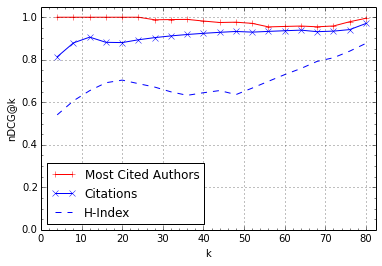

In [21]:
features  = list(common_features)
baselines = [    
    dict(name='Citations',style='b-x'),
    dict(name='H-Index',style='b--'), 
]

N  = 80
n  = 4

dfrank    = venuerank
relfield  = 'QualisRel'
namefield = 'Vkey'

# filter: only venues evaluated in CS Qualis
dfrank = dfrank[dfrank[relfield]>0]

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_v.eps')

In [16]:
# filter: only venues of IR
dfrank = dfrank[dfrank.index.isin(irvids)] 

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_v.eps')

In [22]:
nconfs = dfrank[dfrank.Vkey.str.contains('conf/')].shape[0]
njournals = dfrank[dfrank.Vkey.str.contains('journals/')].shape[0]
print 'Total of', nconfs, 'confs and', njournals, 'journals'

Total of 736 confs and 347 journals


In [18]:
dfrank[dfrank.index.isin(irvids) & dfrank['H-Index'].isnull()]

NameError: name 'irvids' is not defined

### Venue => Venue

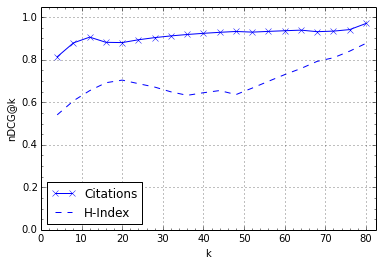

In [19]:
features_ = filter(lambda x: 'Venue' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_vfromv.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Author => Venue

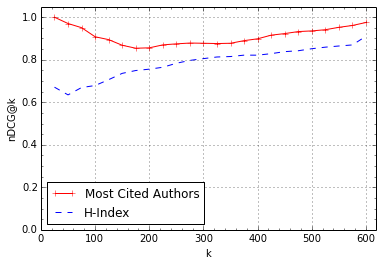

In [62]:
features_ = filter(lambda x: 'Author' in x['name'],features)
plot_ndcg_k(dfrank,features_+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_vfroma.eps')
#plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## II - Author graphs

In [865]:
features = list(common_features)
#features = filter(lambda x: x['name'].split()[0] == 'Groups',features)
baselines= [    
    dict(name='Citations',style='k--'),
    dict(name='H-Index',style='b--'),
]

N  = 400
n  = 25

dfrank    = authorrankbr
relfield  = 'CNPqLevelRel'
namefield = 'Akey'

# filter: only authors evaluated in CNPq
dfrank = dfrank[dfrank[relfield]>0] 
#dfrank = dfrank.dropna()

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_a.eps')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Venue => Author

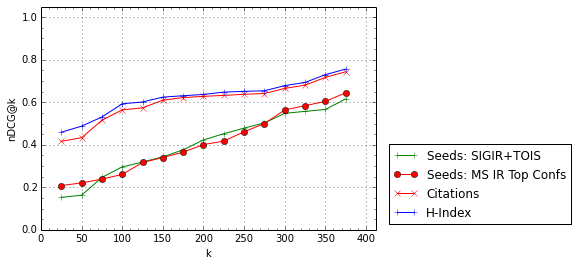

In [999]:
features = list(common_features)
baselines = [    
    dict(name='Citations',style='r-x'),
    dict(name='H-Index',style='b-+'), 
]
N  = 400
n  = 25

dfrank    = authorrankbr
relfield  = 'CNPqLevelRel'
namefield = 'Akey'

# filter: only authors evaluated in CNPq
dfrank = dfrank[dfrank[relfield]>0]

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_afromv.eps')
plt.legend(loc='lower right', bbox_to_anchor=(1.6, 0.0))

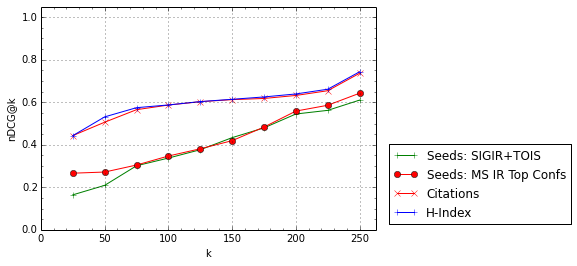

In [1002]:
# TODO: More seed venues -> more authors
features = list(common_features)
baselines = [    
    dict(name='Citations',style='r-x'),
    dict(name='H-Index',style='b-+'), 
]
N  = 255
n  = 25

# filter: only authors of IR
dfrank = dfrank[dfrank['index'].isin(iraids)] 

plot_ndcg_k(dfrank,features+baselines,relfield,namefield,N=N,n=n,verbose=False,filename='figs/rank_afromv.eps')
plt.legend(loc='lower right', bbox_to_anchor=(1.6, 0.0))